### SVR(Support Vector Regression)은 SVM을 회귀 적용 모델
##### SVM(Soft Vector Machine)SVR SVM 서포트 벡터 머신의 변형 모델. 
* SVM은 데이터 포인트를 분류에 사용 적합,
* SVR은 목표 데이터 포인트가 최대 허용 오차 이내에 있도록 하며, 
포인트가 가까워지도록 만드는 것이 핵심. 연속적인 값을 예측하는하는데 사용 적합.

In [15]:
from IPython.display import display, HTML as HTML_display
html_content = f'''
<div style="border: 3px solid red; border-radius: 10px; padding: 20px; background-color: #f9f9f9;">
    <h2 style="color: #000;"><strong>SVR model inside an SVM model</strong></h2>

    <h3 style="color: #000;"><strong>5개 비교지표 SVR모델</strong></h3>
    <ul>
        <li style="color: #000;"><strong>stock_df:</strong>'sc_date', 'sc_ss_stock': 날짜 , 삼성주가</li>
        <li style="color: #000;"><strong>main_economic:</strong>'mei_date', 'mei_gold', 'mei_sp500', 'mei_kospi' : 날짜 , 금가, S&P500, 코스피 </li>
        <li style="color: #000;"><strong>korea_economic:</strong> 'kei_date', 'kei_m2_avg', 'kei_fr' : 날짜, M2통화공급(평잔),외환보유액</li>
    </ul>

    <h3 style="color: #000;"><strong>DATA</strong></h3>
    <ul>
        <li style="color: #000;"> <strong>Total Data: 3614</strong></li>
        <li style="color: #000;"><strong>X_train</strong> 학습 데이터(8) : 2891 (피처 값) </li>
        <li style="color: #000;"><strong>X_test</strong> 테스트 데이터(2) : 723 (피처 값)</li>
        <li style="color: #000;"><strong>y_train</strong> : 723 (타겟 값)</li>
        <li style="color: #000;"><strong>y_train_pred, y_test_pred:</strong> 예측 값</li>
        <li style="color: #000;"><strong>data: </strong>날짜 및 종가를 포함한 데이터프레임</li>
    </ul>

    <h3 style="color: #000;"><strong>Grid-search</strong></h3>
    <ul>
        <li style="color: #000;"> <strong>'C': 1500</strong></li>
        <li style="color: #000;"><strong>'epsilon': 0.01</strong> </li>
        <li style="color: #000;"><strong>'gamma': 0.01</strong></li>
        <li style="color: #000;"><strong>'kernel': 'rbf'</strong></li>

    </ul>

    <h3 style="color: #000;">Performance Metrics</h3>
    <ul>
        <li style="color: #000;"><strong>Mean Squared Error (MSE):</strong> {mse:.4f}</li>
        <li style="color: #000;"><strong>Root Mean Squared Error (RMSE):</strong>{rmse:.4f} </li>
        <li style="color: #000;"><strong>Mean Absolute Error (MAE):</strong>{mae:.4f} </li>
        <li style="color: #000;"> <strong>Decision Coefficient (R<sup>2</sup>):</strong>{r2:.4f} </li>
    </ul>

    <h3 style="color:#000;">Model Status</h3>
    <p style="color: #000;"><strong>과적합 가능성: 모델이 학습 데이터에 비해 테스트 데이터에서 성능이 낮음.</strong></p>

<h2 style="color:#4CAF50;"><strong>에로사항</strong></h2>
<P style="color: #000;">
    <strong><스케일링></strong></br>
    standard스켈라를 사용하면, 스켈링중에서 표준편차를 이용했기때문에 전처리가 과적합된다. </br>
    하지만 min max를 사용하면, 스케일링에서 [0,1]의 범위내에서 스켈링 되기 때문에 이전 이미지가 흘러내리는 것이 방지된다.</br>  
    하지만, min max이용시 역변을 하여야 한다 이는 => 스켈링값 그대로 가져오기 때문이다. </br>
    역변환을 해서 원래 값으로 복원해야 한다. inverse_transform 메서드를 사용할 수 있다.</br>
</br>
    <strong><파라미터 : 정규화></strong>
    C 범위를 최대치로 끓어 올려, 학습 데이터에 더 강하게 맞춤. </br>
    작을수록 학습데이터는 일반화 된다.</br>
</br>
<strong><전처리 강화></strong>
    차원 축소 PCA 적용 후 시도해본 바 r2값이 오히려 낮춰졌다.</br>
</br>
<strong><교차검증></br></strong>
    폴드 추가 cv=5 에서 10으로 변경해봤으나 값은 같았다.  </P>

</div>
'''
display(HTML_display(html_content))

### 1. 라이브러리

In [45]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but StandardScaler was fitted with feature names")

### 2. 데이터 불러오기 및 전처리

In [46]:
stock_df          = pd.read_excel('../../data/tb_stock.xlsx')
main_economic     = pd.read_excel('../../data/tb_main_economic_index.xlsx')
korea_economic    = pd.read_excel('../../data/tb_korea_economic_indicator.xlsx')

stock_df          = stock_df[['sc_date', 'sc_ss_stock']]
main_economic     = main_economic[['mei_date', 'mei_gold', 'mei_sp500', 'mei_kospi']]
korea_economic    = korea_economic[['kei_date', 'kei_m2_avg', 'kei_fr']]

stock_df.rename(columns={'sc_date' :'date'}, inplace=True)
main_economic.rename(columns={'mei_date' :'date'}, inplace=True)
korea_economic.rename(columns={'kei_date' :'date'}, inplace=True)

merged_df         = pd.merge(stock_df, main_economic, on='date', how='inner')               # 주식 데이터와 주요 경제 지표 데이터 병합
merged_df         = pd.merge(merged_df, korea_economic, on='date', how='inner')             # 위에서 병합한 데이터에 한국 경제 지표 데이터 추가 병합

data = merged_df

# 시계열 데이터 전처리
data['MA_7']     = data['sc_ss_stock'].rolling(window=7).mean()                             # 7일 이동 평균 계산 (주가의 단기적 추세 관찰을 위한 7일 이동 평균 추가)
data['Diff']     = data['sc_ss_stock'].diff()                                               # 주가 차분 계산 (현재 주가에서 이전 주가를 빼서 하루 간의 주가 변동량을 계산)

data             = data.dropna() 

### 3. 데이터 분할 및 정규화

In [47]:
X       = data.drop(['sc_ss_stock', 'date'], axis=1)                                        # 피처와 타겟 변수 분리 (날짜 컬럼 제외)
y       = data['sc_ss_stock']

print(f"전체 데이터 수: {X.shape[0]}")                                                       

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"학습 데이터 수: {X_train.shape[0]}")
print(f"테스트 데이터 수: {X_test.shape[0]}")

print(f'X_train shqpe : {X_train.shape}, y_train shape : {y_train.shape}')
print(f'X_test shqpe : {X_train.shape}, y_test shape : {y_train.shape}')

scaler  = StandardScaler()                                                                  # 특성 스케일링 (정규화)
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

전체 데이터 수: 3614
학습 데이터 수: 2891
테스트 데이터 수: 723
X_train shqpe : (2891, 7), y_train shape : (2891,)
X_test shqpe : (2891, 7), y_test shape : (2891,)


### 4. 그리드 서치

In [48]:
# 3. 모델 학습 및 튜닝 (그리드서치 최적의 파라미터 찾기)
svr = SVR()

param_grid = {
    'C': [100, 500, 1000, 1500],                                                            # C 값은 모델의 규제 강도를 결정합니다. 
                                                                                            # 값이 클수록 학습 데이터에 더 잘 맞추려 하지만 과적합의 위험이 커집니다.
                                                                                            # 값이 작을수록 모델은 더 단순해져서 과적합을 방지하고, 일반화 성능이 높아질 수 있습니다.
                                                                                            # 여기서는 100, 500, 1000, 1500의 값들을 시도하여 최적의 규제 강도를 찾습니다.
    
    'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01],                                        # gamma 값은 RBF 커널 함수의 영향을 받는 범위를 결정합니다.
                                                                                            # 'scale'은 1 / (n_features * X.var())로 설정되어, 데이터의 분산에 비례한 값을 사용합니다.
                                                                                            # 'auto'는 1 / n_features로 설정되어, 특성의 개수에 반비례하는 값을 사용합니다.
                                                                                            # 숫자 값들은 고정된 gamma 값을 의미하며, 작은 값일수록 모델이 넓은 범위의 데이터에 반응하게 되고, 
                                                                                            # 큰 값일수록 좁은 범위에 민감하게 반응합니다.
                                                                                            # 여기서는 'scale', 'auto', 0.0001, 0.001, 0.01의 값들을 시도하여 최적의 값을 찾습니다.
    
    'kernel': ['rbf'],                                                                      # kernel은 데이터의 비선형성을 처리하기 위한 함수입니다.
                                                                                            # 'rbf'는 Radial Basis Function 커널로, 비선형 데이터를 고차원 공간으로 매핑하여 
                                                                                            # 복잡한 패턴을 학습할 수 있습니다.
                                                                                            # 이 그리드 서치에서는 'rbf' 커널만 사용합니다.

    'epsilon': [0.10, 0.5, 0.05, 0.01]                                                      # epsilon 값은 SVR 모델에서 예측 오차의 허용 범위를 설정합니다.
                                                                                            # 모델은 epsilon 값 내의 오차를 허용하며, 그 외의 오차에 대해서만 패널티를 부과합니다.
                                                                                            # 작은 epsilon 값은 모델이 작은 오차에도 민감하게 반응하도록 하고, 
                                                                                            # 큰 epsilon 값은 오차를 더 많이 허용합니다.
                                                                                            # 여기서는 0.10, 0.5, 0.05, 0.01의 값들을 시도하여 최적의 오차 허용 범위를 찾습니다.
}

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2') 
grid_search.fit(X_train, y_train)

best_svr = grid_search.best_estimator_
print(f"최적의 파라미터: {grid_search.best_params_}")

최적의 파라미터: {'C': 1500, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}


### 5. 모델 평가(성능)

In [60]:
y_pred      = best_svr.predict(X_test)                                                                                  

mse         = mean_squared_error(y_test, y_pred)
r2          = r2_score(y_test, y_pred)
mae         = mean_absolute_error(y_test, y_pred)
rmse        = mean_squared_error(y_test, y_pred, squared=False)                                                                

print(f"테스트 데이터 평가:")
print(f"오차 제곱 평균(mse): {mse}")
print(f"테스트 결정 계수 값 (R^2): {r2}")
print(f"절대적 오차 (MAE): {mae}")
print(f"평균의 제곱근을 취한 값 (RMSE): {rmse}")

y_train_pred = best_svr.predict(X_train)
train_mse    = mean_squared_error(y_train, y_train_pred)
train_r2     = r2_score(y_train, y_train_pred)

print(f"\n학습 데이터 평가:")
print(f"학습 데이터셋에 대한 모델의 성능을 평가 (MSE): {train_mse}")
print(f"학습 데이터셋에 대한 모델의 성능을 평가 결정 계수 값 (R^2): {train_r2}")

performance_gap = train_r2 - r2                                                                                             # 학습 데이터셋과 테스트 데이터셋의 성능 차이 계산

print("\n모델 평가:")
if performance_gap > 0.2:
    print("과적합 가능성: 모델이 학습 데이터에 비해 테스트 데이터에서 성능이 낮음.")
elif train_r2 < 0.8 and r2 < 0.8:
    print("과소적합 가능성: 모델이 학습 데이터와 테스트 데이터 모두에서 성능이 낮음.")
elif train_r2 >= 0.8 and r2 >= 0.8:
    print("모델이 잘 일반화되었습니다: 학습 데이터와 테스트 데이터 모두에서 높은 성능을 보임.")
else:
    print("예외적인 상황: 학습 데이터의 성능이 낮으나, 테스트 데이터의 성능이 높은 경우입니다. 일반적으로는 드문 상황입니다.")

C:\Users\mys11\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


테스트 데이터 평가:
오차 제곱 평균(mse): 17999033.648047257
테스트 결정 계수 값 (R^2): 0.7199244638230817
절대적 오차 (MAE): 3017.588044878032
평균의 제곱근을 취한 값 (RMSE): 4242.526799920922

학습 데이터 평가:
학습 데이터셋에 대한 모델의 성능을 평가 (MSE): 1758384.4476653275
학습 데이터셋에 대한 모델의 성능을 평가 결정 계수 값 (R^2): 0.9943866528866566

모델 평가:
과적합 가능성: 모델이 학습 데이터에 비해 테스트 데이터에서 성능이 낮음.


### 6. 시각화 (학습, 테스트)

C:\Users\mys11\AppData\Local\Temp\ipykernel_21980\1086820597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'], errors='coerce')


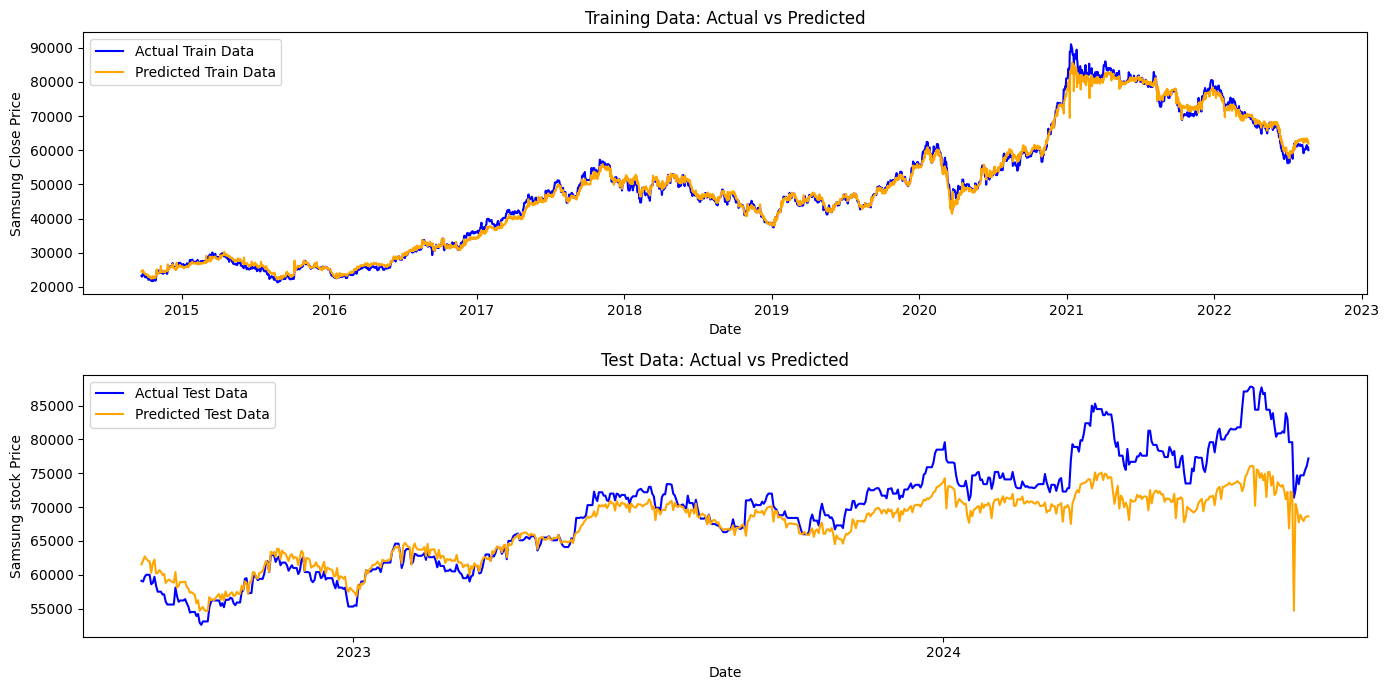

In [50]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')                                                                # 날짜 열을 datetime 형식으로 변환

data = data.dropna(subset=['date'])

y_train_pred = best_svr.predict(X_train)                                                                                    # 학습 데이터와 테스트 데이터에 대한 예측
y_test_pred  = best_svr.predict(X_test)

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)  
plt.plot(data['date'].iloc[:len(y_train)], y_train.values, label='Actual Train Data', color='blue')
plt.plot(data['date'].iloc[:len(y_train)], y_train_pred, label='Predicted Train Data', color='orange')
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Samsung Close Price')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator())                                                                     # x축에 연도만 표시
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.subplot(2, 1, 2)  
plt.plot(data['date'].iloc[len(y_train):], y_test.values, label='Actual Test Data', color='blue')
plt.plot(data['date'].iloc[len(y_train):], y_test_pred, label='Predicted Test Data', color='orange')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Samsung stock Price')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

### 7. 시각화 ( 학습, 테스트, 잔차 )

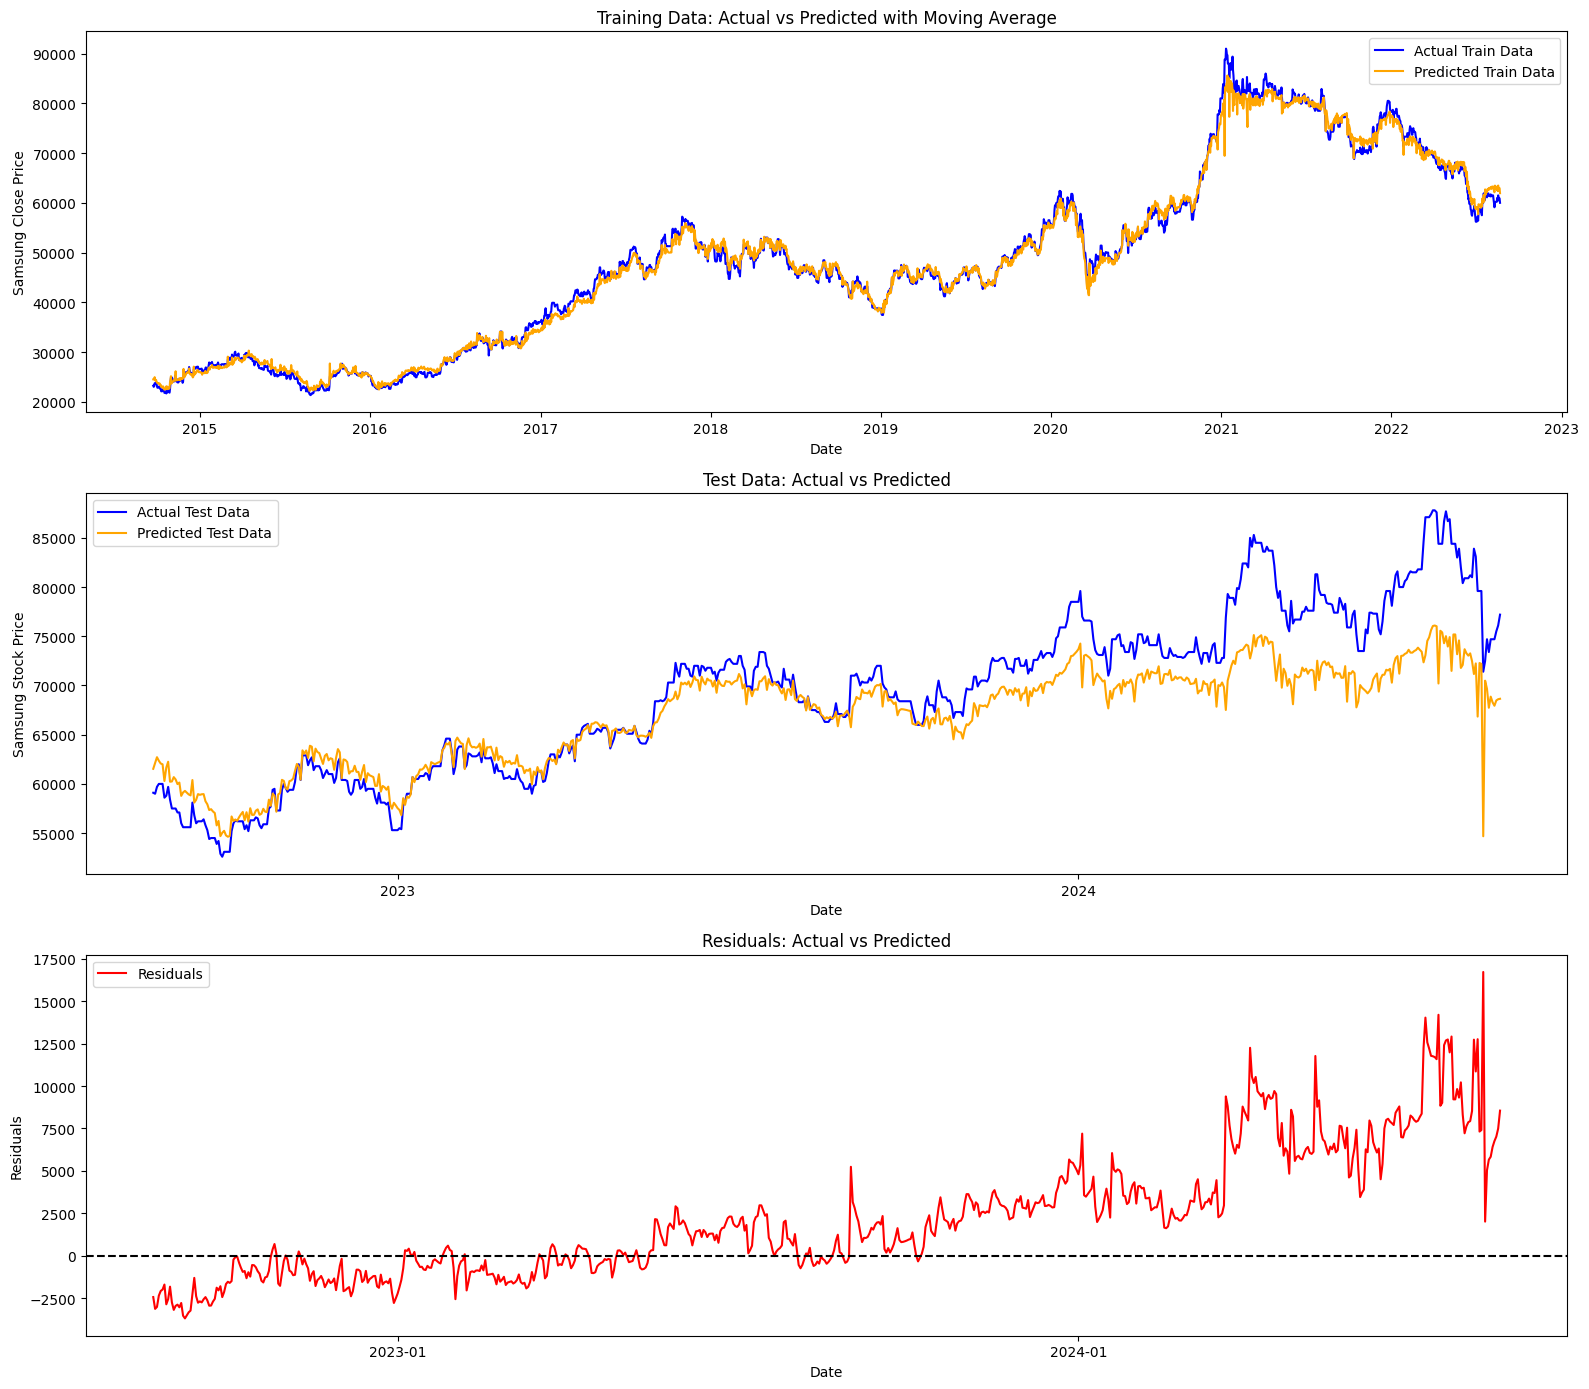

In [51]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')

data = data.dropna(subset=['date'])

# 학습 데이터와 테스트 데이터에 대한 예측
y_train_pred = best_svr.predict(X_train)
y_test_pred  = best_svr.predict(X_test)

# 학습 데이터 시각화
plt.figure(figsize=(16, 14))

# 학습 데이터 시각화
plt.subplot(3, 1, 1)  
plt.plot(data['date'].iloc[:len(y_train)], y_train.values, label='Actual Train Data', color='blue')
plt.plot(data['date'].iloc[:len(y_train)], y_train_pred, label='Predicted Train Data', color='orange')
plt.title('Training Data: Actual vs Predicted with Moving Average')
plt.xlabel('Date')
plt.ylabel('Samsung Close Price')
plt.legend()

# x축에 연도만 표시
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.subplot(3, 1, 2)                                                                                                               # 테스트 데이터 시각화
plt.plot(data['date'].iloc[len(y_train):], y_test.values, label='Actual Test Data', color='blue')
plt.plot(data['date'].iloc[len(y_train):], y_test_pred, label='Predicted Test Data', color='orange')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Samsung Stock Price')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator())                                                                            
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

residuals   = y_test - y_test_pred                                                                                                  # 잔차 분석
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 subplot
plt.plot(data['date'].iloc[len(y_train):], residuals, label='Residuals', color='red')
plt.axhline(0, color='black', linestyle='--')                                                                
plt.title('Residuals: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator())                                                                             # x축에 연도만 표시
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [58]:
# 5. 4주 예측 학습 
last_train_date = data['date'].iloc[len(y_train) - 1]                                               # 데이터의 마지막 날짜

# 4주 후 예측 날짜 계산
prediction_date = last_train_date + timedelta(weeks=4)

# 마지막 데이터 포인트 추출 및 데이터프레임 생성
last_train_data = X_test[-1:]  # 마지막 데이터 포인트 추출
last_train_df = pd.DataFrame(last_train_data, columns=X.columns)

# 스케일링 적용
input_scaled = scaler.transform(last_train_df)

# 예측 수행
predicted_value = loaded_model.predict(input_scaled)

# 예측된 값 확인
print(f"예측된 값 (원본): {predicted_value}")

# 예측된 값이 음수일 경우 0으로 변경
predicted_value = np.maximum(predicted_value, 0)

# 예측된 값의 형태를 확인하고 필요할 경우 형식을 변경
if predicted_value.ndim == 1:
    predicted_value = predicted_value.reshape(-1, 1)

# 예측된 값의 스케일 복원 (필요한 경우, 예: StandardScaler를 적용한 경우)
# 예를 들어 y_scaler가 적용되었다면:
# predicted_value = y_scaler.inverse_transform(predicted_value)

# 결과 출력
print(f"마지막 학습 날짜: {last_train_date}")
print(f"예측 날짜: {prediction_date}")
print(f"예측된 삼성전자 종가: {predicted_value[0][0]:.2f}")

예측된 값 (원본): [40182.24402069]
마지막 학습 날짜: 2022-08-22 00:00:00
예측 날짜: 2022-09-19 00:00:00
예측된 삼성전자 종가: 40182.24


### 8. 예측값 테스트

In [53]:
last_train_data = X_test[-1:]                                                                               # 마지막 데이터 포인트 추출
last_train_df = pd.DataFrame(last_train_data, columns=X.columns)

input_scaled = scaler.transform(last_train_df)                                                              # 스케일링 적용
prediction_date = last_train_date + timedelta(weeks=4)                                                      # 4주 후 예측 날짜 계산

predicted_value = loaded_model.predict(input_scaled)

print(f"마지막 학습 날짜: {last_train_date}")
print(f"예측 날짜: {prediction_date}")
print(f"예측된 삼성전자 종가: {predicted_value[0]:.2f}")

마지막 학습 날짜: 2022-08-22 00:00:00
예측 날짜: 2022-09-19 00:00:00
예측된 삼성전자 종가: 40182.24


### 9. 결과 시각화

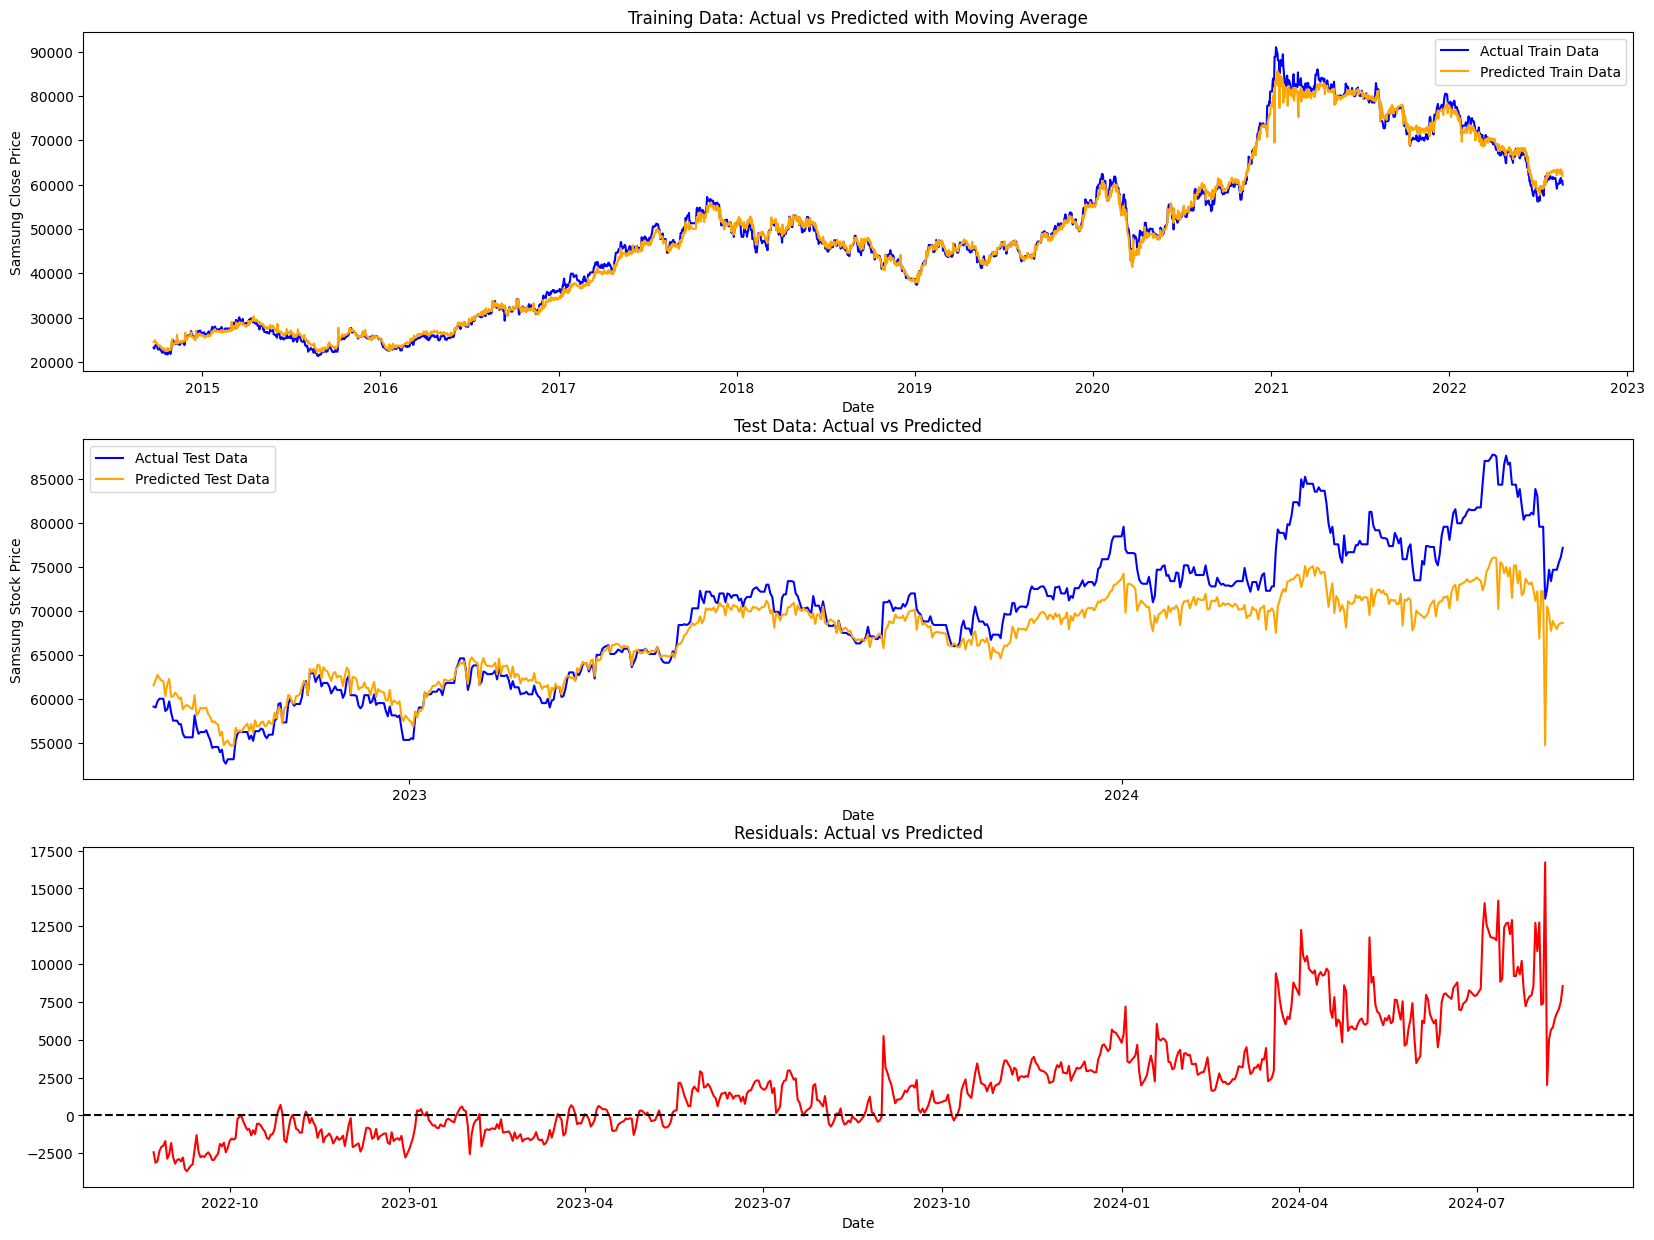

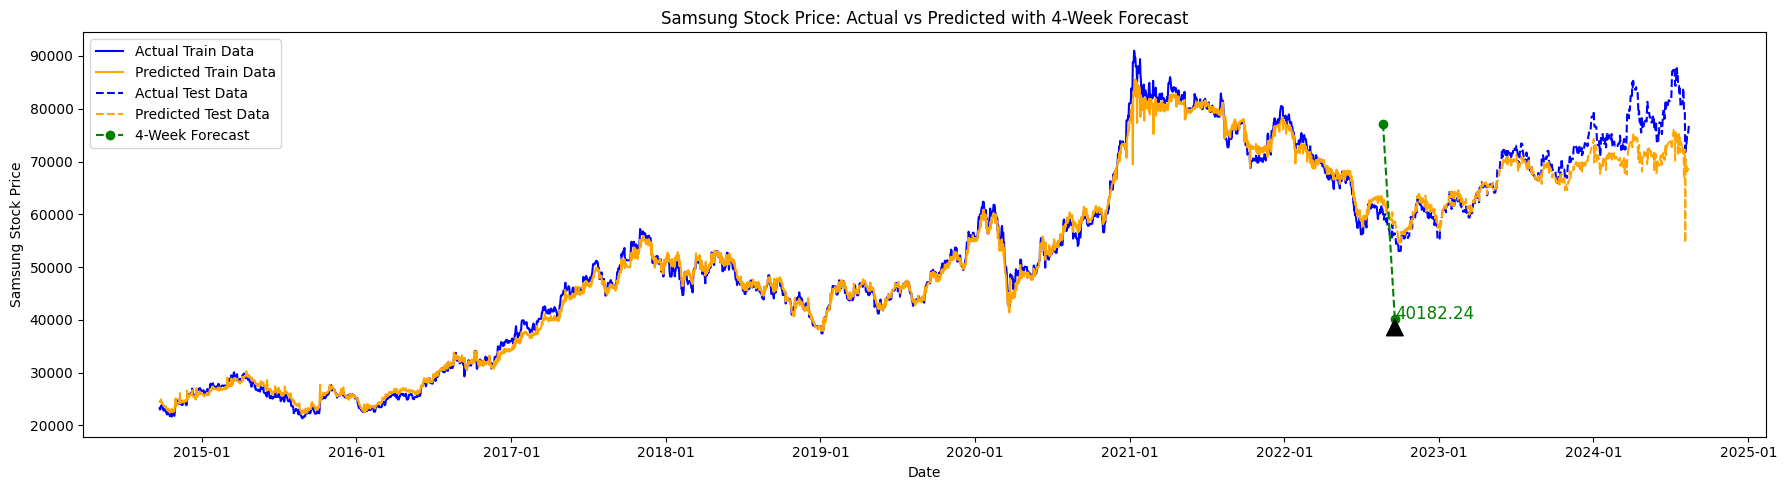

In [54]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data = data.dropna(subset=['date'])

y_train_pred = best_svr.predict(X_train)                                                                   
y_test_pred = best_svr.predict(X_test)

plt.figure(figsize=(20, 15))

# 학습 데이터 시각화
plt.subplot(3, 1, 1) 
plt.plot(data['date'].iloc[:len(y_train)], y_train.values, label='Actual Train Data', color='blue')
plt.plot(data['date'].iloc[:len(y_train)], y_train_pred, label='Predicted Train Data', color='orange')

plt.title('Training Data: Actual vs Predicted with Moving Average')
plt.xlabel('Date')
plt.ylabel('Samsung Close Price')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


plt.subplot(3, 1, 2) 
plt.plot(data['date'].iloc[len(y_train):], y_test.values, label='Actual Test Data', color='blue')
plt.plot(data['date'].iloc[len(y_train):], y_test_pred, label='Predicted Test Data', color='orange')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Samsung Stock Price')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


residuals = y_test - y_test_pred
plt.subplot(3, 1, 3)  
plt.plot(data['date'].iloc[len(y_train):], residuals, label='Residuals', color='red')
plt.axhline(0, color='black', linestyle='--')  
plt.title('Residuals: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel

plt.figure(figsize=(18, 5))                                                                                                                                                 # 예측 결과를 포함한 시계열 플롯 생성
plt.plot(data['date'].iloc[:len(y_train)], y_train.values, label='Actual Train Data', color='blue')
plt.plot(data['date'].iloc[:len(y_train)], y_train_pred, label='Predicted Train Data', color='orange')
plt.plot(data['date'].iloc[len(y_train):], y_test.values, label='Actual Test Data', color='blue', linestyle='--')
plt.plot(data['date'].iloc[len(y_train):], y_test_pred, label='Predicted Test Data', color='orange', linestyle='--')

plt.plot([last_train_date, prediction_date], [data['sc_ss_stock'].iloc[-1], predicted_value[0]], label='4-Week Forecast', color='green', linestyle='--', marker='o')        # 4주 후 예측 결과 시각화
plt.annotate(f'{predicted_value[0]:.2f}', xy=(prediction_date, predicted_value[0]), xytext=(prediction_date, predicted_value[0] + 0.1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=12, color='green')

plt.title('Samsung Stock Price: Actual vs Predicted with 4-Week Forecast')
plt.xlabel('Date')
plt.ylabel('Samsung Stock Price')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

### 10. 산점도 시각화

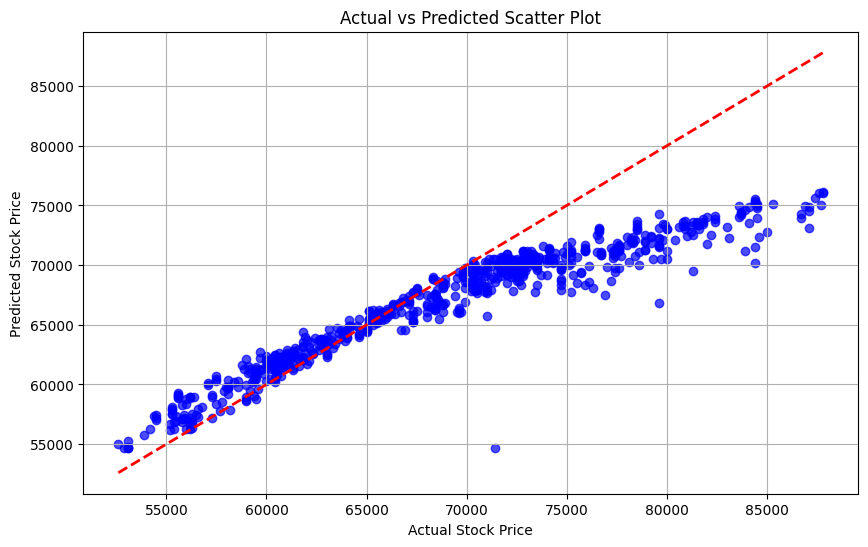

In [55]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Scatter Plot')
plt.xlabel('Actual Stock Price')
plt.ylabel('Predicted Stock Price')
plt.grid(True)
plt.show()

### 11. 모델 저장

In [56]:
model_filename = 'regression_samsung_svm.joblib'
joblib.dump(scaler, 'regression_samsung_svm_scaler.joblib')
joblib.dump(best_svr, model_filename)
print(f"모델이 '{model_filename}'로 저장되었습니다.")

모델이 'regression_samsung_svm.joblib'로 저장되었습니다.


### 12. 모델 불러오기 

In [57]:
# 11. 저장된 모델 불러오기
loaded_model = joblib.load('regression_samsung_svm.joblib')
print("모델이 성공적으로 불러와졌습니다.")

# 모델을 사용하여 예측 수행
y_test_pred_loaded = loaded_model.predict(X_test)

모델이 성공적으로 불러와졌습니다.
